In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


#### a) all weights initialized to 0

In [4]:
class PyTorchNN_zero(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PyTorchNN_zero, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc1.weight.data = torch.zeros_like(self.fc1.weight.data)
        self.fc2.weight.data = torch.zeros_like(self.fc2.weight.data)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [5]:
def model_test_torch(model_torch, dataset=testloader):
    correct_test = 0
    total_test = 0
    total_loss = 0
    for images, labels in dataset:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
    test_accuracy = correct_test / total_test
    test_error = 1 - test_accuracy
    # print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")
    total_loss = total_loss/len(dataset)
    return test_error, total_loss

In [6]:
learning_rate = 0.1
epochs = 50
input_dim = 28*28
hidden_dim = 300
output_dim = 10

model_torch = PyTorchNN_zero(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=learning_rate)

training_losses_torch = []
test_losses_torch = []
test_errors_torch = []
for epoch in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()

        outputs = model_torch(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    training_losses_torch.append(total_loss/len(trainloader))
    test_error_torch, total_loss_torch = model_test_torch(model_torch)
    test_losses_torch.append(total_loss_torch)
    test_errors_torch.append(test_error_torch)
    print(f"Epoch {epoch+1}, Loss: {training_losses_torch[-1]}, Test Loss: {test_losses_torch[-1]}, Test Error: {100 * test_error_torch}%")


Epoch 1, Loss: 2.299794164547788, Test Loss: 2.2946112049613028, Test Error: 88.64999999999999%
Epoch 2, Loss: 2.271259960335201, Test Loss: 2.2241172501995305, Test Error: 82.01%
Epoch 3, Loss: 2.1830328486875685, Test Loss: 2.1144782570516987, Test Error: 63.349999999999994%
Epoch 4, Loss: 2.0486719138078344, Test Loss: 2.0057259532296734, Test Error: 54.83%
Epoch 5, Loss: 1.9318987377671037, Test Loss: 1.8632385624442132, Test Error: 35.629999999999995%
Epoch 6, Loss: 1.8127479565931535, Test Loss: 1.7650460498348164, Test Error: 27.280000000000005%
Epoch 7, Loss: 1.7456408750527956, Test Loss: 1.7328230233708763, Test Error: 25.5%
Epoch 8, Loss: 1.726381216857479, Test Loss: 1.7219357741106847, Test Error: 25.129999999999995%
Epoch 9, Loss: 1.7179431588665, Test Loss: 1.7153402931371313, Test Error: 24.61%
Epoch 10, Loss: 1.7125911421613145, Test Loss: 1.709980639682454, Test Error: 24.3%
Epoch 11, Loss: 1.682204111552696, Test Loss: 1.6508855515984213, Test Error: 17.42%
Epoch 12,

In [7]:
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_error = 1 - test_accuracy

print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")

Accuracy: 94.58%, Test Error: 5.420000000000003%


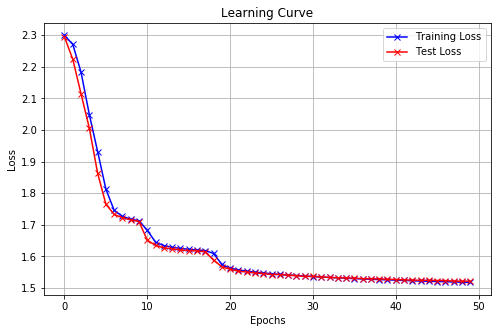

In [8]:
fig1 = plt.figure(figsize=(8, 5))
plt.plot(training_losses_torch, marker='x', label="Training Loss", color="blue")
plt.plot(test_losses_torch, marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
fig1.savefig('learning_curve_torch_zero_weight.png', dpi=300)

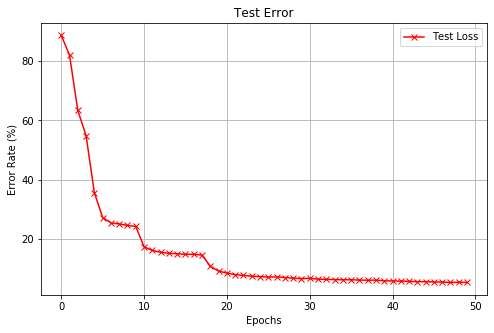

In [9]:
fig11 = plt.figure(figsize=(8, 5))
plt.plot(100*np.array(test_errors_torch), marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error Rate (%)")
plt.title("Test Error")
plt.legend()
plt.grid(True)
plt.show()
fig11.savefig('test_error_torch_zero_weight.png', dpi=300)

#### b) initialize the weights randomly between -1 and 1

In [52]:
class PyTorchNN_unif(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PyTorchNN_unif, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        init.uniform_(self.fc1.weight, -1, 1)
        init.uniform_(self.fc2.weight, -1, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [53]:
def model_test_torch(model_torch, dataset=testloader):
    correct_test = 0
    total_test = 0
    total_loss = 0
    for images, labels in dataset:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
    test_accuracy = correct_test / total_test
    test_error = 1 - test_accuracy
    # print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")
    total_loss = total_loss/len(dataset)
    return test_error, total_loss

In [55]:
learning_rate = 0.1
epochs = 50
input_dim = 28*28
hidden_dim = 300
output_dim = 10

model_torch = PyTorchNN_unif(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=learning_rate)

training_losses_torch = []
test_losses_torch = []
test_errors_torch = []
for epoch in range(epochs):
    total_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()

        outputs = model_torch(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    training_losses_torch.append(total_loss/len(trainloader))
    test_error_torch, total_loss_torch = model_test_torch(model_torch)
    test_losses_torch.append(total_loss_torch)
    test_errors_torch.append(test_error_torch)
    print(f"Epoch {epoch+1}, Loss: {training_losses_torch[-1]}, Test Loss: {test_losses_torch[-1]}, Test Error: {100 * test_error_torch}%")


Epoch 1, Loss: 2.045471073849115, Test Loss: 1.91181712697266, Test Error: 44.45%
Epoch 2, Loss: 1.8747552551948694, Test Loss: 1.8471718996193758, Test Error: 38.480000000000004%
Epoch 3, Loss: 1.8382359730409408, Test Loss: 1.8288984670760526, Test Error: 36.58%
Epoch 4, Loss: 1.8227819591951269, Test Loss: 1.8182858881677033, Test Error: 35.699999999999996%
Epoch 5, Loss: 1.8140054614559165, Test Loss: 1.8117970995082977, Test Error: 35.029999999999994%
Epoch 6, Loss: 1.8081860163572754, Test Loss: 1.8069359314669469, Test Error: 34.46%
Epoch 7, Loss: 1.8035016997790794, Test Loss: 1.8018077619516166, Test Error: 34.0%
Epoch 8, Loss: 1.779781551757601, Test Loss: 1.750109642933888, Test Error: 28.110000000000003%
Epoch 9, Loss: 1.734219117967813, Test Loss: 1.6998353528369003, Test Error: 22.819999999999997%
Epoch 10, Loss: 1.6751537784330373, Test Loss: 1.6612184639948948, Test Error: 19.179999999999996%
Epoch 11, Loss: 1.6546749471347215, Test Loss: 1.6496587202047845, Test Error:

In [56]:
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        outputs = model_torch.forward(images)
        predicted = torch.argmax(outputs, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
test_error = 1 - test_accuracy

print(f"Accuracy: {100 * test_accuracy}%, Test Error: {100 * test_error}%")

Accuracy: 85.79%, Test Error: 14.21%


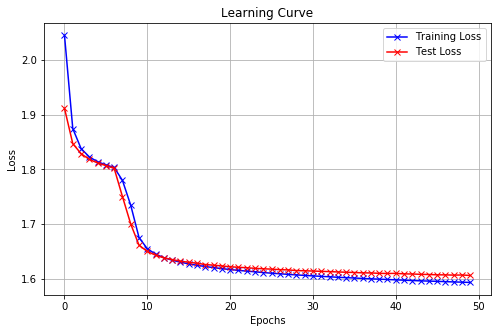

In [59]:
fig2 = plt.figure(figsize=(8, 5))
plt.plot(training_losses_torch, marker='x', label="Training Loss", color="blue")
plt.plot(test_losses_torch, marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
fig2.savefig('learning_curve_torch_uniform_weight.png', dpi=300)

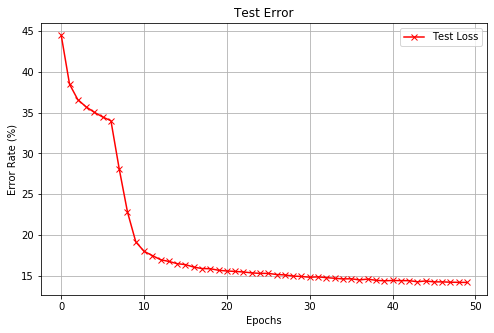

In [60]:
fig22 = plt.figure(figsize=(8, 5))
plt.plot(100*np.array(test_errors_torch), marker='x', label="Test Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Error Rate (%)")
plt.title("Test Error")
plt.legend()
plt.grid(True)
plt.show()
fig22.savefig('test_error_torch_uniform_weight.png', dpi=300)